<a href="https://colab.research.google.com/github/farhanwew/Transcranial-Doppler-Biomed/blob/main/TCD_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

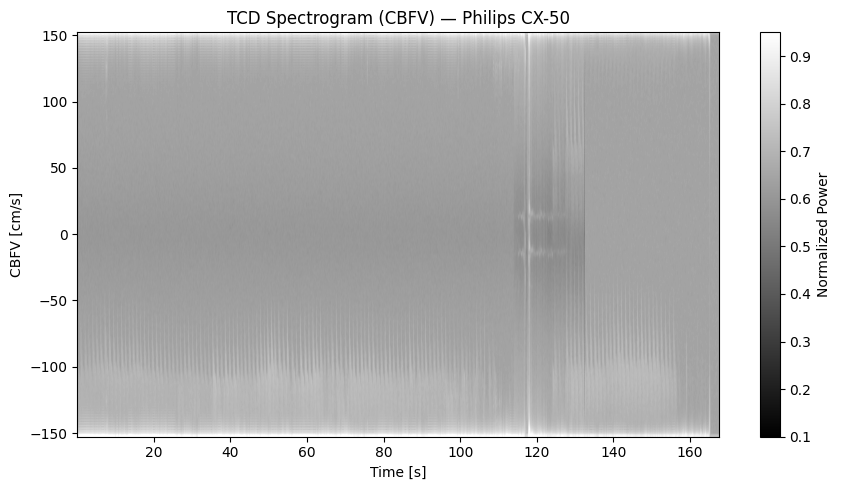

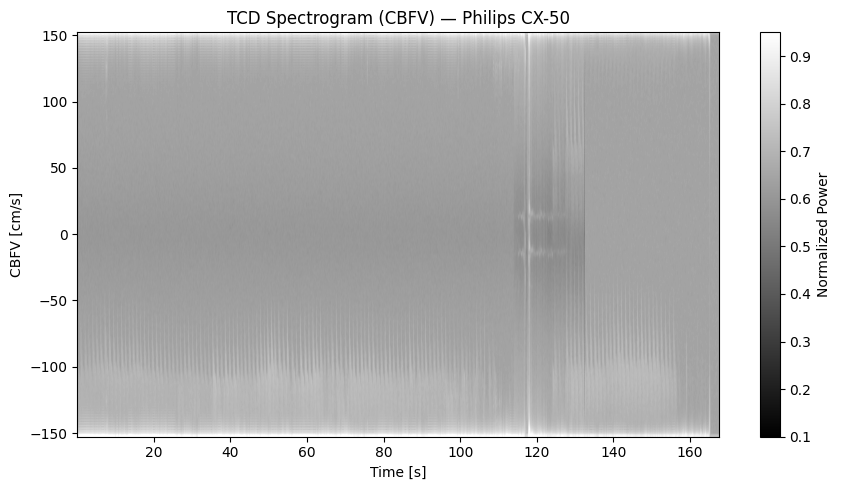

In [ ]:
# tcd_spectrogram.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft, medfilt2d
from typing import Tuple

def correct_timestamp_overflow(t_sec: np.ndarray) -> np.ndarray:
    """
    Perbaiki loncatan negatif pada vektor waktu (overflow counter).
    Mirip logika MATLAB: deteksi diff < -median(diff) lalu geser segmen berikutnya.
    """
    t = t_sec.copy()
    diffT = np.diff(t)
    Ts_med = np.median(diffT[diffT > 0]) if np.any(diffT > 0) else np.median(diffT)

    # indeks di mana terjadi loncatan negatif signifikan
    overflow_idx = np.where(diffT < -Ts_med)[0]
    if overflow_idx.size == 0:
        return t

    # tambahkan sentinel akhir agar loop mudah
    overflow_idx = np.concatenate([overflow_idx, [len(t) - 1]])

    for i in range(len(overflow_idx) - 1):
        i0 = overflow_idx[i]
        # DeltaT = |t[i] - t[i+1]| + Ts_med (mengacu skrip MATLAB)
        DeltaT = abs(t[i0] - t[i0 + 1]) + Ts_med
        start = i0 + 1
        end = overflow_idx[i + 1] + 1
        t[start:end] = t[start:end] + DeltaT

    return t

def resample_iq(t_old: np.ndarray, I: np.ndarray, Q: np.ndarray, Ts_target: float
               ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Resample I/Q ke grid waktu seragam dengan interval Ts_target.
    Interpolasi pchip ~ cubic di MATLAB → gunakan cubic spline-ish 'pchip' tidak ada langsung,
    maka dipakai 'cubic' dari pandas/NumPy bila data cukup rapat; fallback ke 'linear'.
    """
    fs_target = 1.0 / Ts_target
    t_new = np.arange(t_old[0], t_old[-1] + 1e-12, Ts_target)

    # gunakan numpy.interp (linear) agar andal; cukup untuk STFT
    I_new = np.interp(t_new, t_old, I)
    Q_new = np.interp(t_new, t_old, Q)
    return t_new, I_new, Q_new, fs_target

def generate_spectrogram(IQ: np.ndarray, fs: float,
                         nperseg: int = 256, noverlap: int = 192, nfft: int = 512
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Hitung spectrogram power dari sinyal kompleks IQ.
    Kembalikan: frekuensi(Hz), waktu(s), Spektrum Power (magnitude^2).
    """
    # STFT pada sinyal kompleks
    f, t, Zxx = stft(IQ, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, window="hann", boundary=None)
    SP = (np.abs(Zxx) ** 2).astype(np.float64)  # power spectrum
    return f, t, SP

def freq_to_velocity(f_hz: np.ndarray, fc: float, c: float, angle_deg: float) -> np.ndarray:
    """
    Konversi frekuensi Doppler → kecepatan aliran (cm/s)
    v = (f * c) / (2 * fc * cos(theta))  ; lalu ×100 untuk cm/s
    """
    angle_rad = np.deg2rad(angle_deg)
    denom = 2.0 * fc * np.cos(angle_rad)
   # hindari pembagian 0 jika angle=90°
    denom = np.where(np.isclose(denom, 0.0), np.finfo(float).eps, denom)
    v_ms = (f_hz * c) / denom
    return 100.0 * v_ms  # cm/s

def normalize_and_filter(SP: np.ndarray, median_kernel=(3, 3)) -> np.ndarray:
    """
    Log-kompresi, normalisasi 0..1, median filter 2D.
    """
    eps = np.finfo(float).eps
    SP_log = np.log2(SP + eps)
    SP_log -= SP_log.min()
    m = SP_log.max()
    if m > 0:
        SP_norm = SP_log / m
    else:
        SP_norm = SP_log
    SP_med = medfilt2d(SP_norm, kernel_size=median_kernel)
    return SP_med

def plot_spectrogram(t_spec: np.ndarray, v_spec: np.ndarray, SP_proc: np.ndarray,
                     clim=(0.1, 0.95), cmap="gray", title="TCD Spectrogram (CBFV)") -> None:
    plt.figure(figsize=(9, 5))
    # extent: [xmin, xmax, ymin, ymax]; origin='lower' ≈ axis xy di MATLAB
    extent = [t_spec.min(), t_spec.max(), v_spec.min(), v_spec.max()]
    img = plt.imshow(SP_proc, aspect="auto", extent=extent, origin="lower", cmap=cmap)
    if clim is not None:
        img.set_clim(*clim)
    plt.xlabel("Time [s]")
    plt.ylabel("CBFV [cm/s]")
    plt.title(title)
    plt.colorbar(label="Normalized Power")
    plt.tight_layout()
    plt.show()

def main(
    filepath: str = "../Healthy Subjects/Healthy_Subjects_Recording_1.txt",
    sep: str = ",",
    fc: float = 1.75e6,   # Hz, carrier (Philips CX-50 example)
    c_sound: float = 1540.0,  # m/s
    angle_deg: float = 0.0,
    Ts_target: float = 1.44e-4,  # s → fs ≈ 6944 Hz
    nperseg: int = 256,
    noverlap: int = 192,
    nfft: int = 512,
    clim: Tuple[float, float] = (0.1, 0.95),
):
    # 1) Load data
    # Jika file pakai delimiter tab/spasi, set sep=r"\s+" dan engine="python"
    df = pd.read_csv(filepath, sep=sep, engine="python")
    # Asumsi kolom bernama 't', 'I', 'Q'
    t = df["t"].to_numpy(dtype=np.float64)
    I = df["I"].to_numpy(dtype=np.float64)
    Q = df["Q"].to_numpy(dtype=np.float64)

    # 2) Zeroing timestamp & ubah mikrodetik → detik (seperti MATLAB)
    t = (t - t[0]) / 1e6

    # 3) Koreksi overflow timestamp
    t = correct_timestamp_overflow(t)

    # 4) Resample ke grid seragam
    t_uniform, Iu, Qu, fs = resample_iq(t, I, Q, Ts_target)
    IQ = Iu + 1j * Qu

    # 5) Spectrogram (STFT)
    f_sp, t_sp, SP = generate_spectrogram(IQ, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

    # 6) Frekuensi → kecepatan (cm/s)
    v_sp = freq_to_velocity(f_sp, fc=fc, c=c_sound, angle_deg=angle_deg)

    # 7) Log-normalisasi + median filter
    SP_proc = normalize_and_filter(SP, median_kernel=(3, 3))

    # 8) Visualisasi
    plot_spectrogram(t_sp, v_sp, SP_proc, clim=clim, cmap="gray",
                     title="TCD Spectrogram (CBFV) — Philips CX-50")

if __name__ == "__main__":
    # Contoh pemanggilan default:
    main(filepath="/kaggle/input/tcd-ultrasound-data/Healthy Subjects/Healthy Subjects/Healthy_Subjects_Recording_1.txt", sep=",")
    main(filepath="/kaggle/input/tcd-ultrasound-data/Healthy Subjects/Healthy Subjects/Healthy_Subjects_Recording_1.txt", sep=",")

# ICU Patient

File loaded successfully!
Data shape: (4222524, 3)
Data loaded: 4222524 samples

Total duration: 621.19 seconds (10.35 minutes)
Sampling frequency: 6944.44 Hz

Generating full spectrogram...


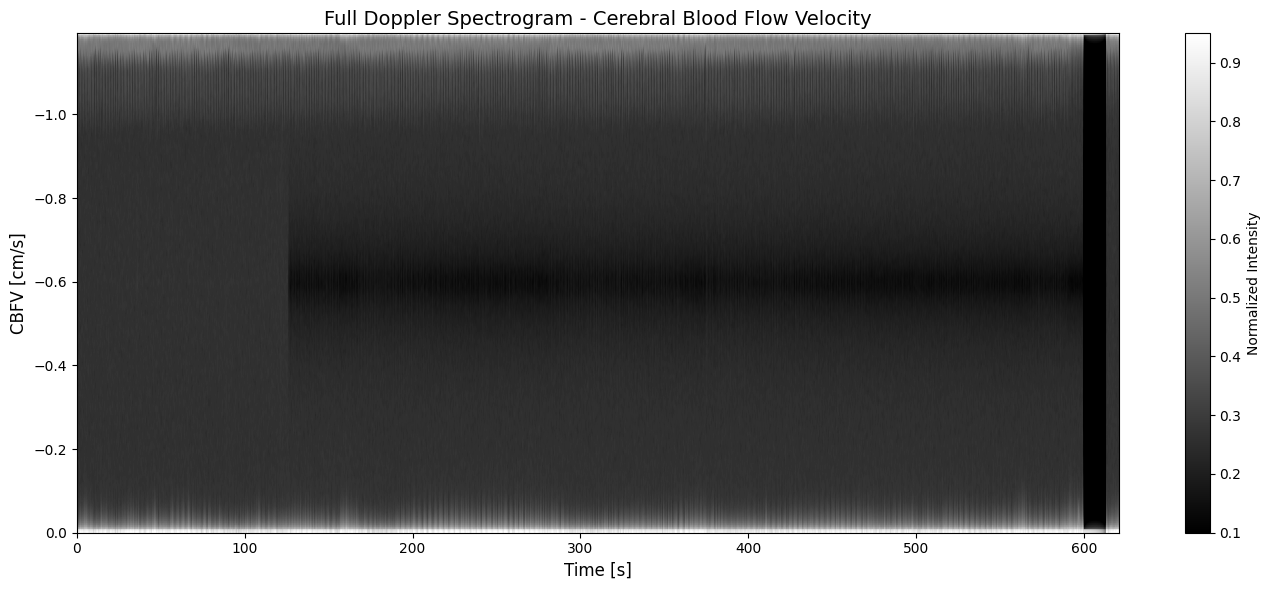


Generating per-minute spectrograms...
Number of minutes: 11


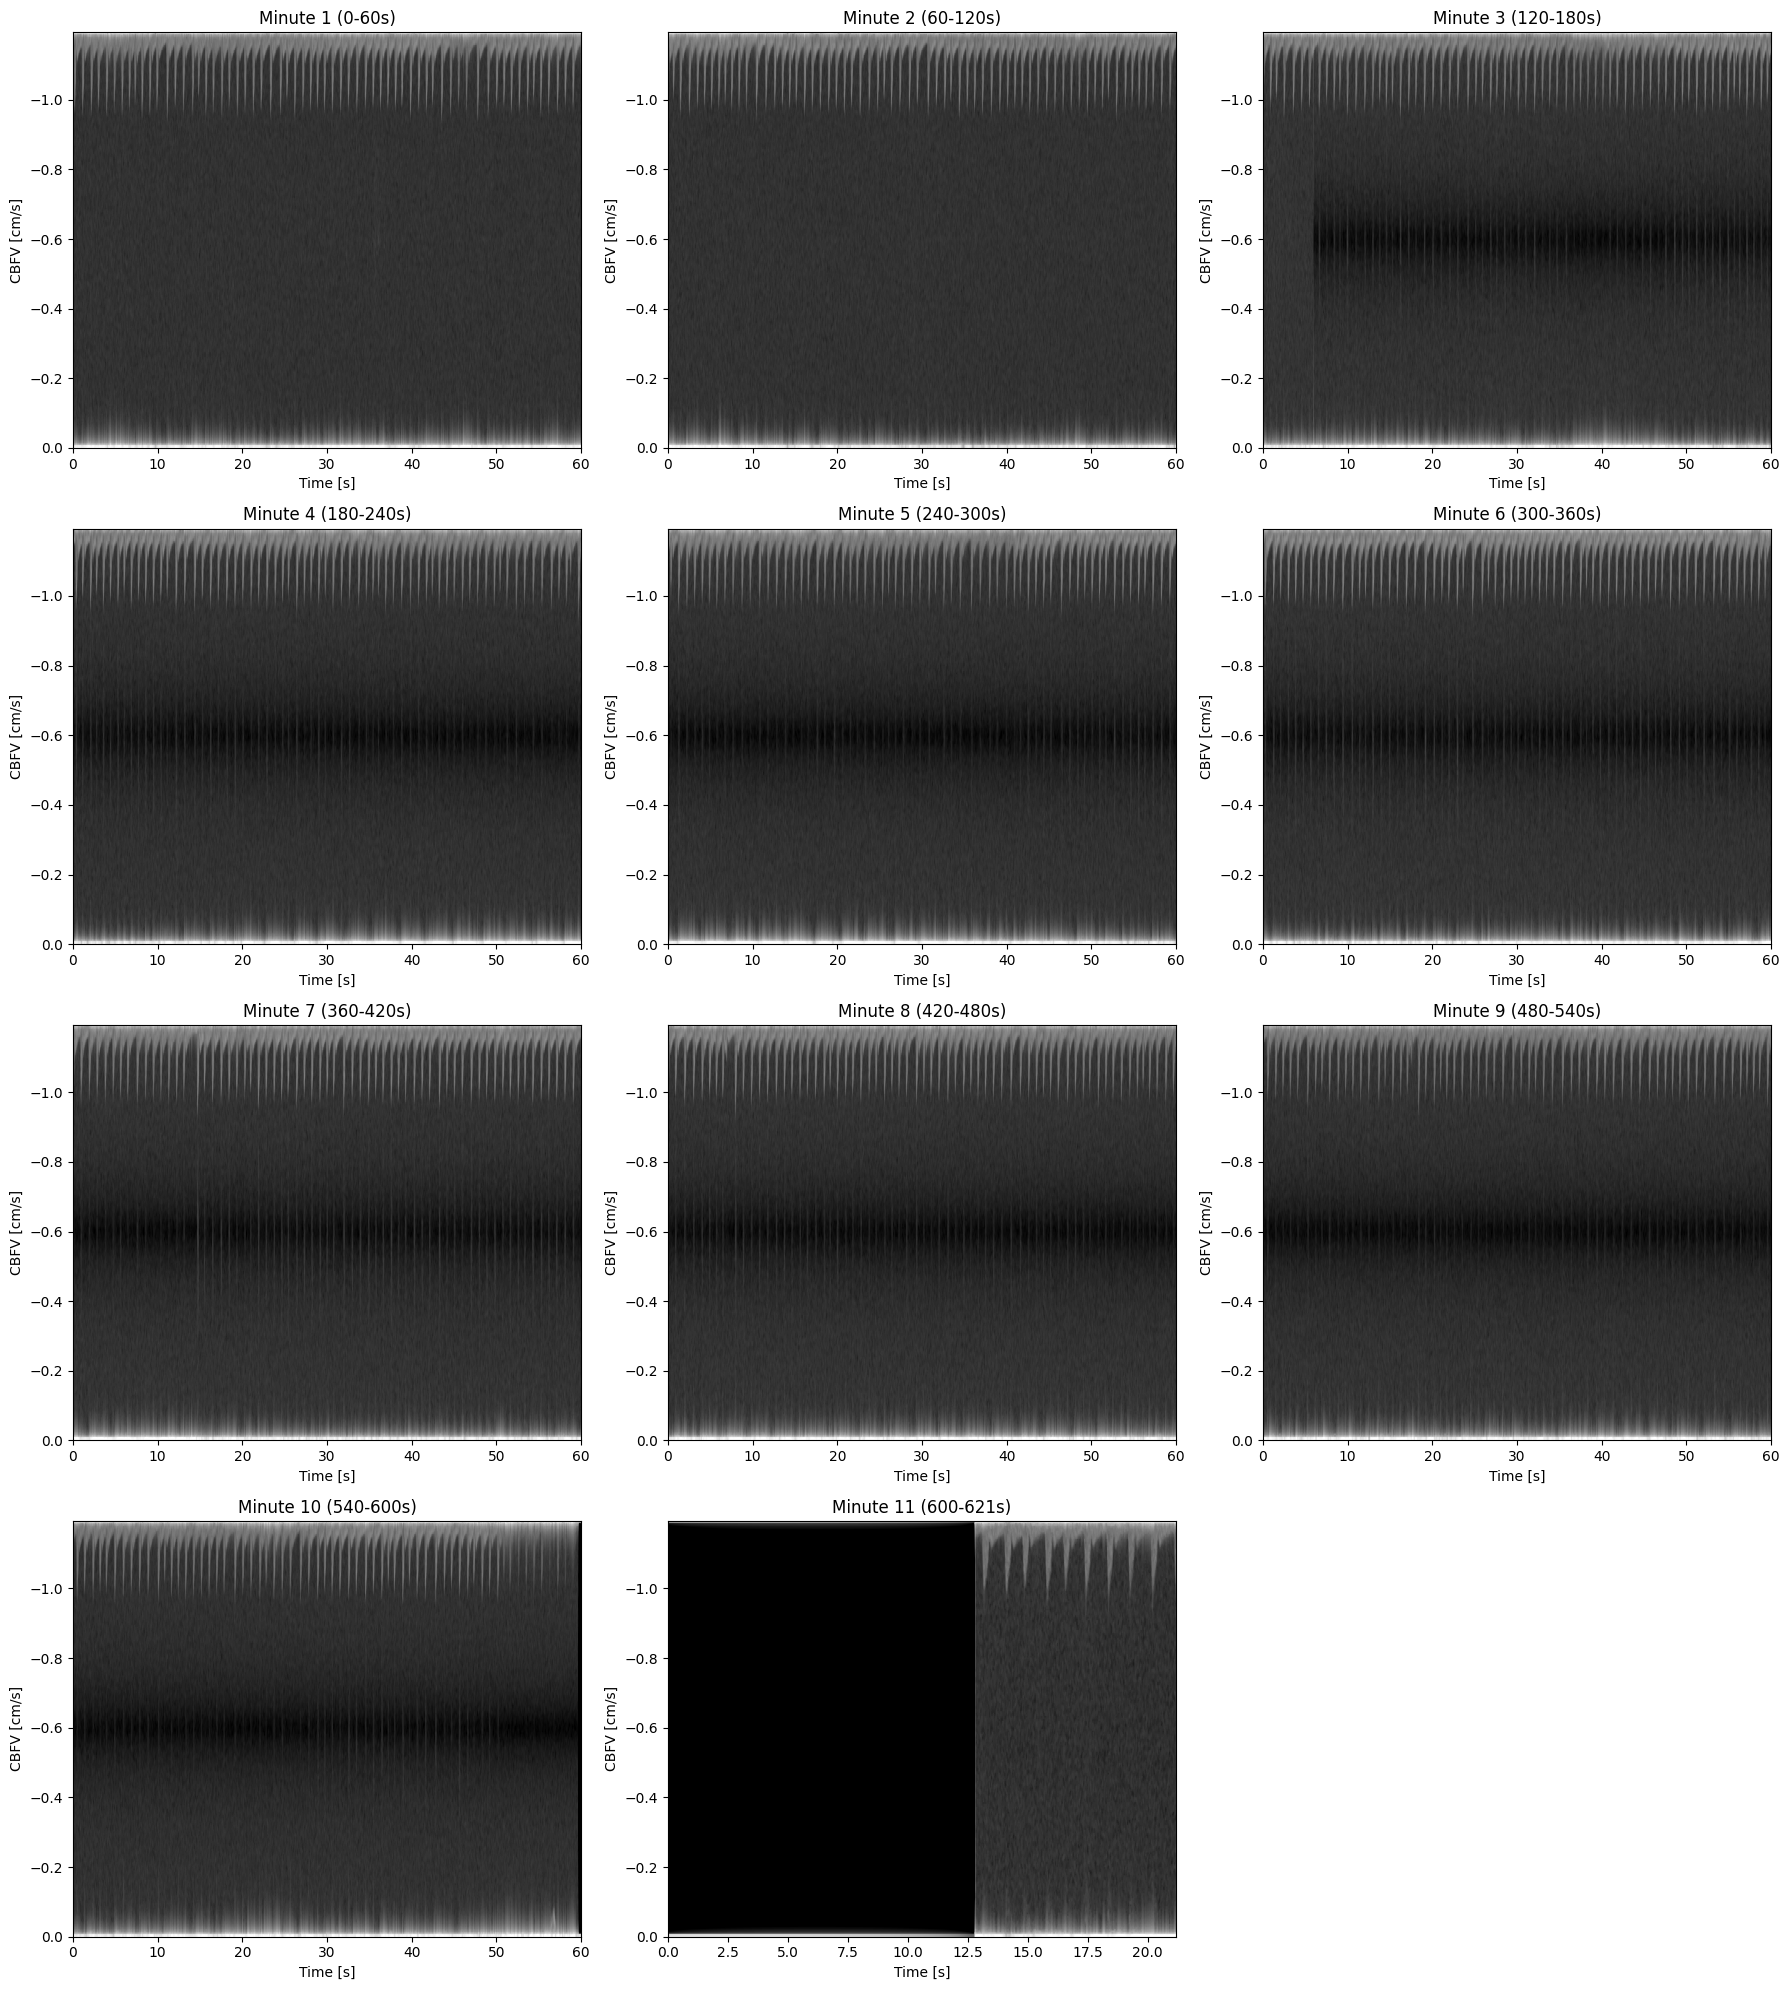


Generating box plots...


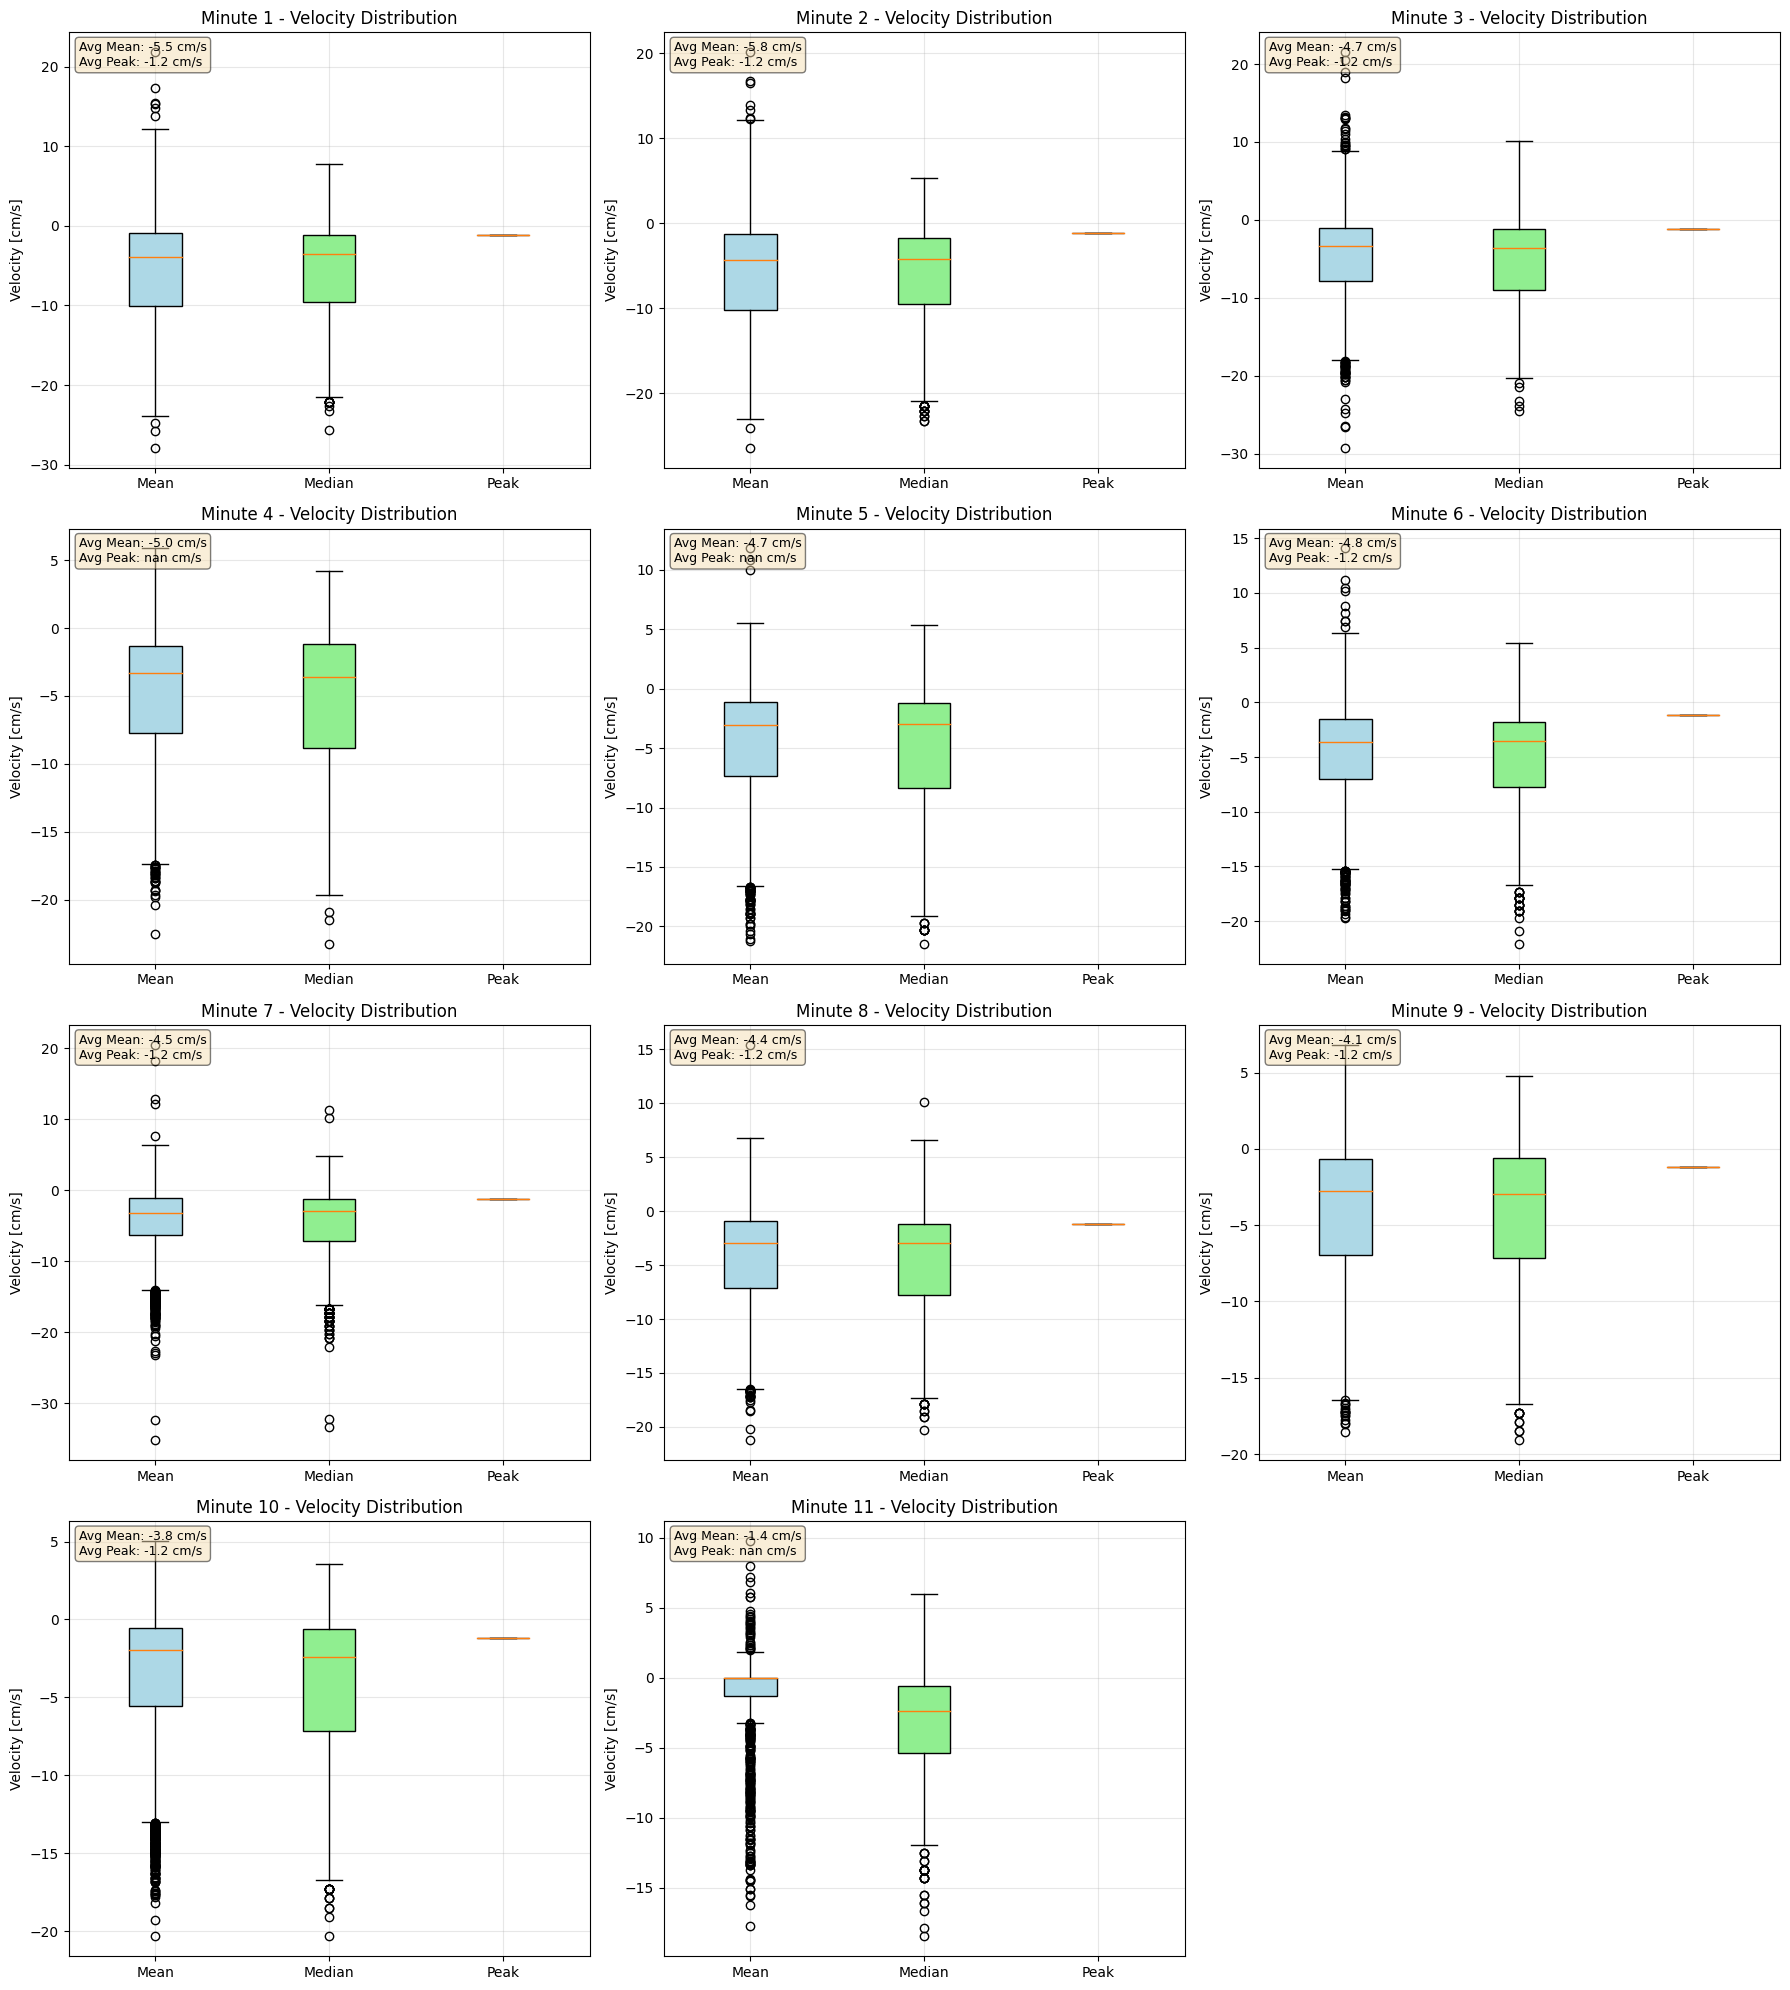


✓ Analysis complete!
Total minutes analyzed: 11
Grid layout: 4 rows × 3 columns


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import median_filter

def generate_spectrogram(iq_signal, fs, t_echo, nperseg=256, noverlap=None):
    """Generate spectrogram from IQ signal"""
    if noverlap is None:
        noverlap = nperseg // 2

    # Compute STFT for complex signal (two-sided spectrum)
    freqs, t_spec, Zxx = signal.stft(iq_signal, fs=fs,
                                      nperseg=nperseg,
                                      noverlap=noverlap,
                                      window='hann',
                                      return_onesided=False)

    # Compute magnitude
    spec = np.abs(Zxx)

    return freqs, t_spec, spec, fs


def extract_velocity_stats(SP, v_spectrogram, threshold=0.3):
    """Extract velocity statistics from spectrogram"""
    stats = []

    for col in range(SP.shape[1]):
        spectrum = SP[:, col]
        # Get indices where signal is above threshold
        valid_idx = spectrum > threshold

        if np.any(valid_idx):
            velocities = v_spectrogram[valid_idx]
            intensities = spectrum[valid_idx]

            # Weighted statistics
            mean_vel = np.average(velocities, weights=intensities)
            max_vel = velocities[np.argmax(intensities)]

            # Percentiles
            sorted_vels = np.sort(velocities)
            p25 = np.percentile(sorted_vels, 25)
            p50 = np.percentile(sorted_vels, 50)
            p75 = np.percentile(sorted_vels, 75)

            stats.append({
                'mean': mean_vel,
                'max': max_vel,
                'min': np.min(velocities),
                'p25': p25,
                'p50': p50,
                'p75': p75
            })
        else:
            stats.append({
                'mean': 0, 'max': 0, 'min': 0,
                'p25': 0, 'p50': 0, 'p75': 0
            })

    return stats


# ============================================================================
# PARAMETERS
# ============================================================================
fc = 1.75e6  # Transmit center frequency [Hz]
ss = 1540    # Speed of sound [m/s]
angle = 0    # Doppler angle [deg]
size_sp_filt = (3, 3)  # Median filter kernel size

# ============================================================================
# LOAD DATA
# ============================================================================
filepath = ''
filename = '/kaggle/input/tcd-ultrasound-data/ICU Patients/ICU Patients/ICU_Patients_Recording_10_ICA.txt'

data = pd.read_csv(filepath + filename)
print("File loaded successfully!")
print(f"Data shape: {data.shape}")

t_echo = data['t'].values
I = data['I'].values
Q = data['Q'].values

print(f"Data loaded: {len(t_echo)} samples")

# ============================================================================
# PREPROCESSING
# ============================================================================
# Zero timestamp and convert to seconds
t_echo = (t_echo - t_echo[0]) / 1e6
diff_t = np.diff(t_echo)
Ts_echo = np.median(diff_t)

# Correct for overflow
overflow_index = np.where(diff_t < -Ts_echo)[0]
overflow_index = np.append(overflow_index, len(t_echo) - 1)

for i in range(len(overflow_index) - 1):
    delta_t = abs(t_echo[overflow_index[i]] - t_echo[overflow_index[i] + 1]) + Ts_echo
    win = slice(overflow_index[i] + 1, overflow_index[i + 1] + 1)
    t_echo[win] = t_echo[win] + delta_t

# Resample IQ signal
Ts_echo = 1.4400e-04
fs_echo = 1 / Ts_echo
t_uniform = np.arange(t_echo[0], t_echo[-1], Ts_echo)

I_interp = PchipInterpolator(t_echo, I)
Q_interp = PchipInterpolator(t_echo, Q)

I = I_interp(t_uniform)
Q = Q_interp(t_uniform)
IQ = I + 1j * Q
t_echo = t_uniform

duration_total = t_echo[-1]
print(f"\nTotal duration: {duration_total:.2f} seconds ({duration_total/60:.2f} minutes)")
print(f"Sampling frequency: {fs_echo:.2f} Hz")

# ============================================================================
# FULL SPECTROGRAM
# ============================================================================
print("\nGenerating full spectrogram...")
freqs_sp, t_spectrogram, SP_full, fs_sp = generate_spectrogram(IQ, fs_echo, t_echo)

# Convert frequency to velocity
v_spectrogram = 100 * freqs_sp * ss / (2 * fc * np.cos(np.radians(angle)))

# Process spectrum
SP_full = np.log2(SP_full + 1e-10)
SP_full = SP_full / np.max(SP_full)
SP_full = median_filter(SP_full, size=size_sp_filt)

# Plot full spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(SP_full, aspect='auto', origin='lower',
           extent=[t_spectrogram[0], t_spectrogram[-1],
                   v_spectrogram[0], v_spectrogram[-1]],
           cmap='gray', vmin=0.1, vmax=0.95)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('CBFV [cm/s]', fontsize=12)
plt.title('Full Doppler Spectrogram - Cerebral Blood Flow Velocity', fontsize=14)
plt.colorbar(label='Normalized Intensity')
plt.tight_layout()
plt.show()

# ============================================================================
# PER-MINUTE SPECTROGRAMS
# ============================================================================
print("\nGenerating per-minute spectrograms...")

# Calculate number of minutes
n_minutes = int(np.ceil(duration_total / 60))
print(f"Number of minutes: {n_minutes}")

# Calculate grid layout
n_cols = 3
n_rows = int(np.ceil(n_minutes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

minute_stats = []

for minute in range(n_minutes):
    # Time window for this minute
    t_start = minute * 60
    t_end = min((minute + 1) * 60, duration_total)

    # Find indices for this minute
    idx_start = np.searchsorted(t_echo, t_start)
    idx_end = np.searchsorted(t_echo, t_end)

    if idx_end - idx_start < 100:  # Skip if too few samples
        continue

    # Extract data for this minute
    IQ_minute = IQ[idx_start:idx_end]
    t_minute = t_echo[idx_start:idx_end] - t_start

    # Generate spectrogram
    freqs_min, t_spec_min, SP_min, _ = generate_spectrogram(IQ_minute, fs_echo, t_minute)

    # Convert to velocity
    v_min = 100 * freqs_min * ss / (2 * fc * np.cos(np.radians(angle)))

    # Process
    SP_min = np.log2(SP_min + 1e-10)
    SP_min = SP_min / np.max(SP_min)
    SP_min = median_filter(SP_min, size=size_sp_filt)

    # Extract statistics
    stats = extract_velocity_stats(SP_min, v_min)
    minute_stats.append({
        'minute': minute + 1,
        'mean_velocities': [s['mean'] for s in stats],
        'max_velocities': [s['max'] for s in stats],
        'p50_velocities': [s['p50'] for s in stats]
    })

    # Plot
    row = minute // n_cols
    col = minute % n_cols
    ax = axes[row, col]

    im = ax.imshow(SP_min, aspect='auto', origin='lower',
                   extent=[t_spec_min[0], t_spec_min[-1], v_min[0], v_min[-1]],
                   cmap='gray', vmin=0.1, vmax=0.95)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('CBFV [cm/s]')
    ax.set_title(f'Minute {minute+1} ({t_start:.0f}-{t_end:.0f}s)')

# Remove empty subplots
for minute in range(n_minutes, n_rows * n_cols):
    row = minute // n_cols
    col = minute % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# ============================================================================
# BOX PLOTS - 3 x N GRID (CORRECTED)
# ============================================================================
print("\nGenerating box plots...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, stats in enumerate(minute_stats):
    if i >= n_minutes:
        break

    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Prepare data for box plot
    mean_vels = np.array(stats['mean_velocities'])
    max_vels = np.array(stats['max_velocities'])
    p50_vels = np.array(stats['p50_velocities'])

    # Remove zeros for better visualization
    mean_vels = mean_vels[mean_vels != 0]
    max_vels = max_vels[max_vels != 0]
    p50_vels = p50_vels[p50_vels != 0]

    # Check if we have data to plot to avoid errors with empty arrays
    if len(mean_vels) > 0:
        # Box plot - CHANGED 'tick_labels' TO 'labels'
        bp = ax.boxplot([mean_vels, p50_vels, max_vels],
                       labels=['Mean', 'Median', 'Peak'],
                       patch_artist=True)

        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Add statistics text
        mean_avg = np.mean(mean_vels)
        max_avg = np.mean(max_vels)
        ax.text(0.02, 0.98, f'Avg Mean: {mean_avg:.1f} cm/s\nAvg Peak: {max_avg:.1f} cm/s',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    else:
        ax.text(0.5, 0.5, 'No valid signal', ha='center', va='center')

    ax.set_ylabel('Velocity [cm/s]')
    ax.set_title(f'Minute {stats["minute"]} - Velocity Distribution')
    ax.grid(True, alpha=0.3)


# Remove empty subplots
for i in range(len(minute_stats), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
print(f"Total minutes analyzed: {len(minute_stats)}")
print(f"Grid layout: {n_rows} rows × {n_cols} columns")

# Healthy Patient

File loaded successfully!
Data shape: (3803966, 3)
Data loaded: 3803966 samples

Total duration: 552.02 seconds (9.20 minutes)
Sampling frequency: 6944.44 Hz

Generating full spectrogram...


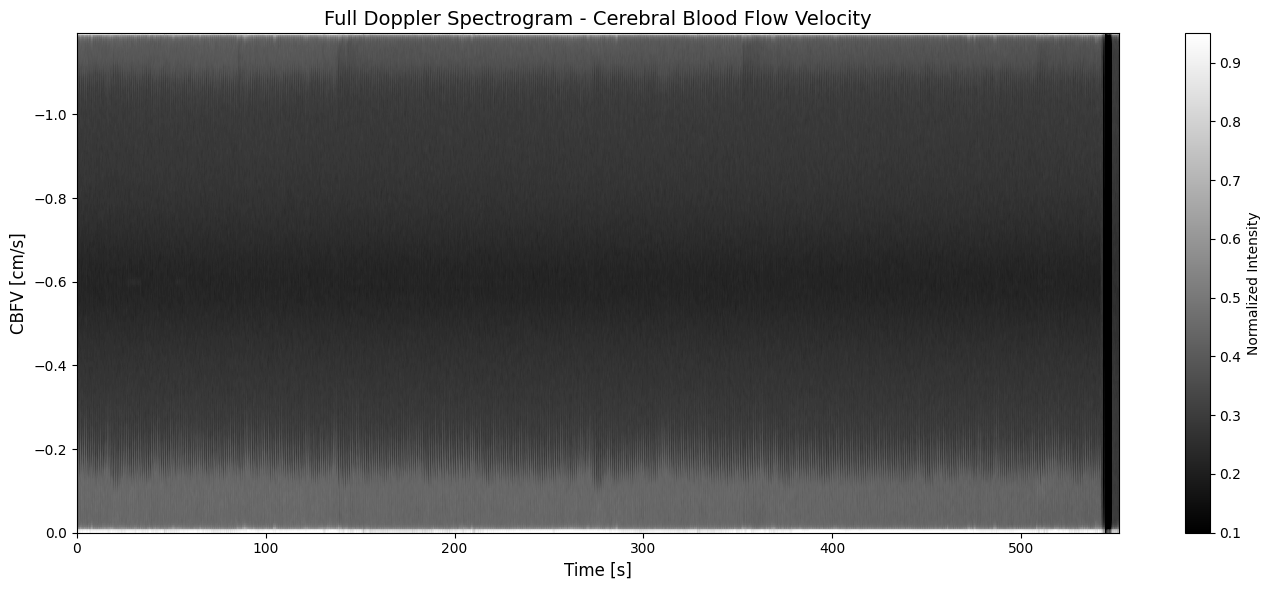


Generating per-minute spectrograms...
Number of minutes: 10


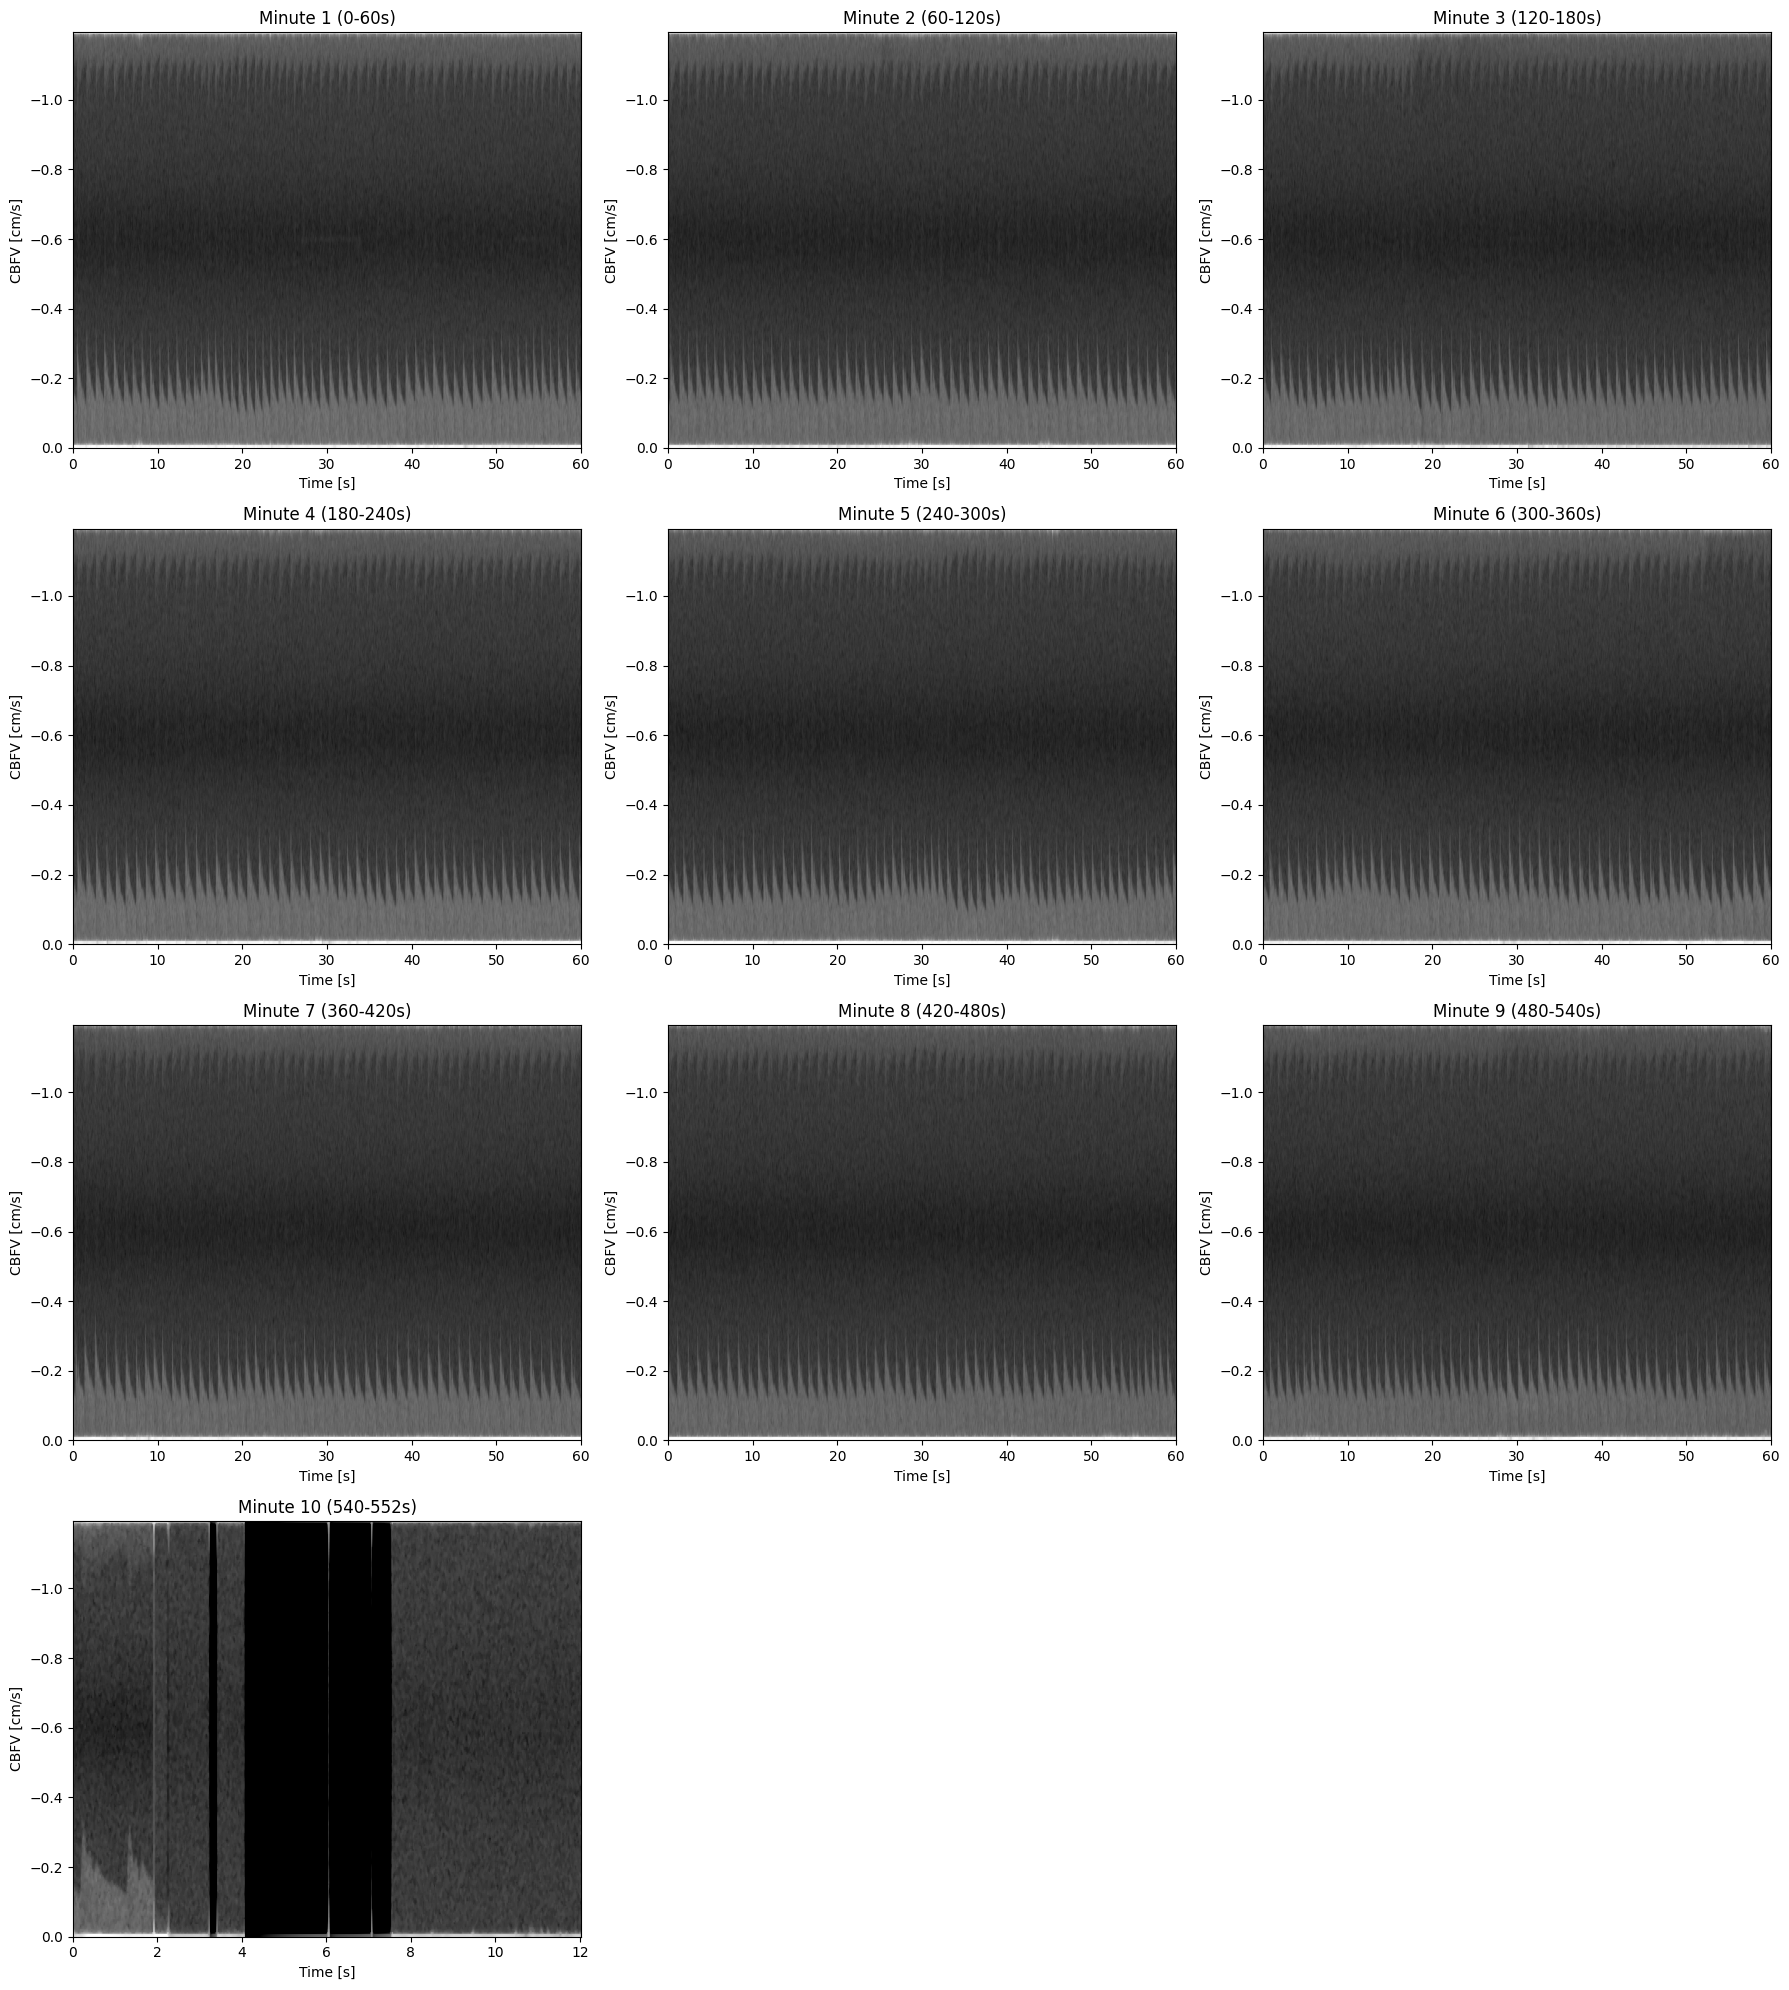


Generating box plots...


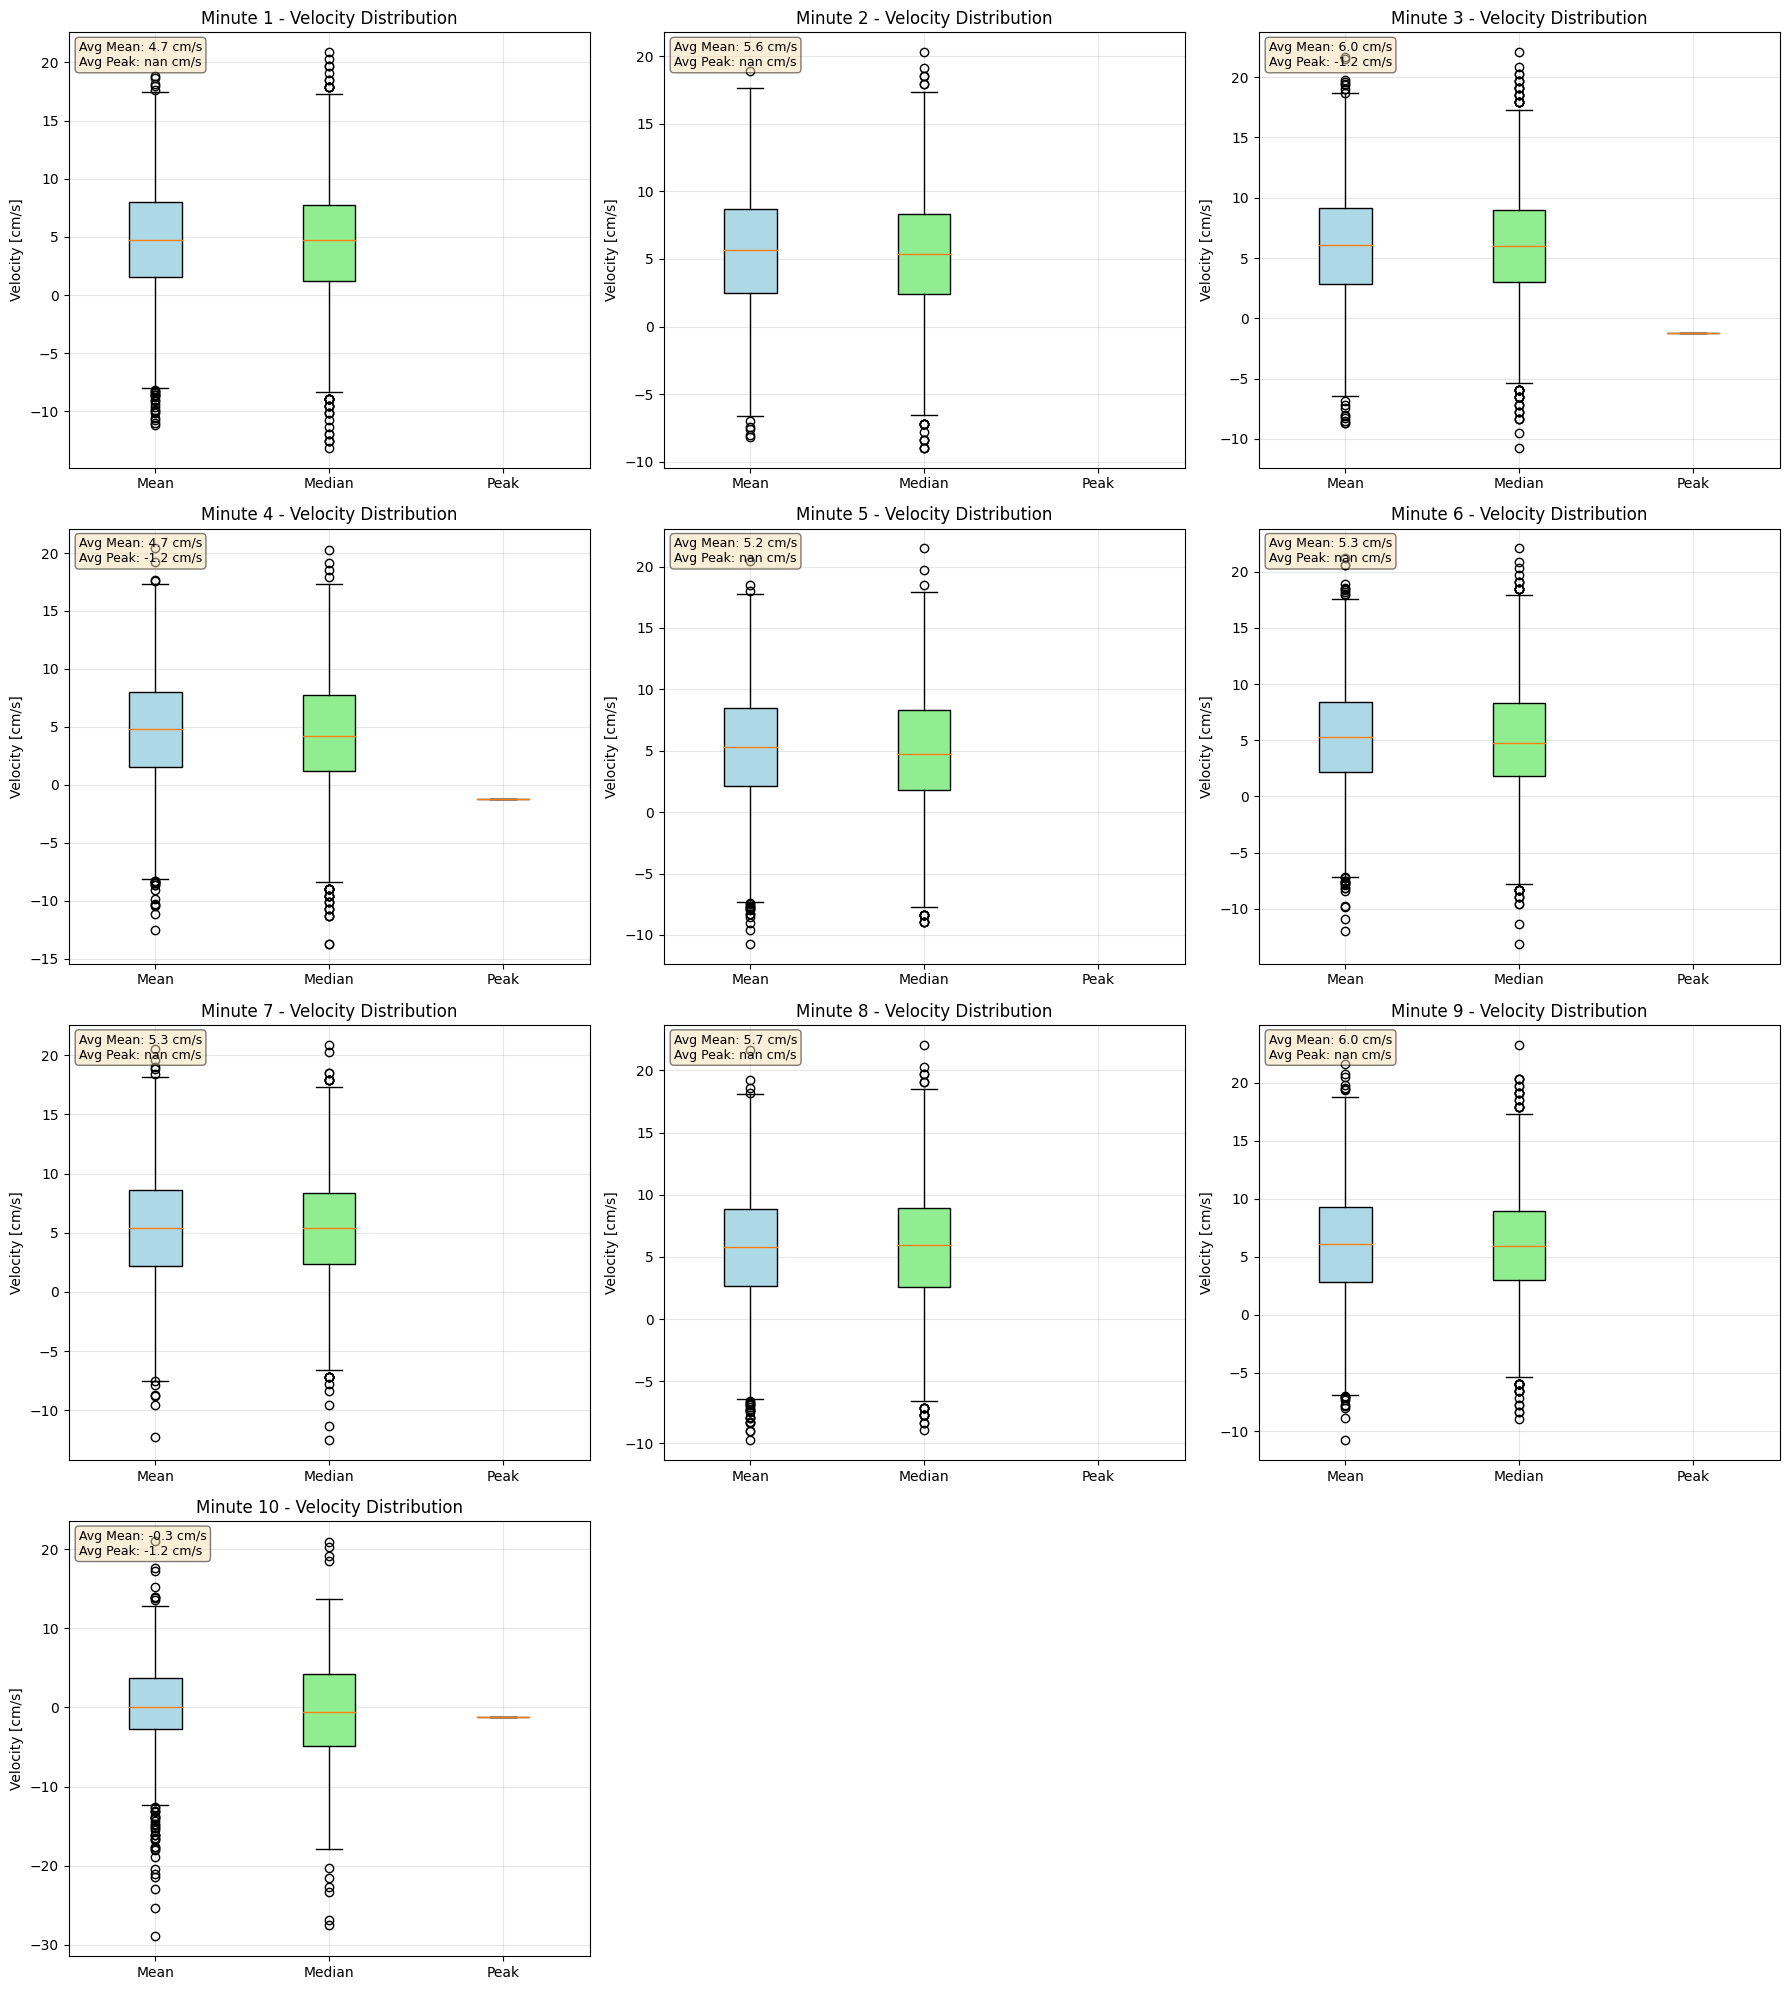


✓ Analysis complete!
Total minutes analyzed: 10
Grid layout: 4 rows × 3 columns


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import median_filter

def generate_spectrogram(iq_signal, fs, t_echo, nperseg=256, noverlap=None):
    """Generate spectrogram from IQ signal"""
    if noverlap is None:
        noverlap = nperseg // 2

    # Compute STFT for complex signal (two-sided spectrum)
    freqs, t_spec, Zxx = signal.stft(iq_signal, fs=fs,
                                      nperseg=nperseg,
                                      noverlap=noverlap,
                                      window='hann',
                                      return_onesided=False)

    # Compute magnitude
    spec = np.abs(Zxx)

    return freqs, t_spec, spec, fs


def extract_velocity_stats(SP, v_spectrogram, threshold=0.3):
    """Extract velocity statistics from spectrogram"""
    stats = []

    for col in range(SP.shape[1]):
        spectrum = SP[:, col]
        # Get indices where signal is above threshold
        valid_idx = spectrum > threshold

        if np.any(valid_idx):
            velocities = v_spectrogram[valid_idx]
            intensities = spectrum[valid_idx]

            # Weighted statistics
            mean_vel = np.average(velocities, weights=intensities)
            max_vel = velocities[np.argmax(intensities)]

            # Percentiles
            sorted_vels = np.sort(velocities)
            p25 = np.percentile(sorted_vels, 25)
            p50 = np.percentile(sorted_vels, 50)
            p75 = np.percentile(sorted_vels, 75)

            stats.append({
                'mean': mean_vel,
                'max': max_vel,
                'min': np.min(velocities),
                'p25': p25,
                'p50': p50,
                'p75': p75
            })
        else:
            stats.append({
                'mean': 0, 'max': 0, 'min': 0,
                'p25': 0, 'p50': 0, 'p75': 0
            })

    return stats


# ============================================================================
# PARAMETERS
# ============================================================================
fc = 1.75e6  # Transmit center frequency [Hz]
ss = 1540    # Speed of sound [m/s]
angle = 0    # Doppler angle [deg]
size_sp_filt = (3, 3)  # Median filter kernel size

# ============================================================================
# LOAD DATA
# ============================================================================
filepath = ''
filename = '/kaggle/input/tcd-ultrasound-data/Healthy Subjects/Healthy Subjects/Healthy_Subjects_Recording_8.txt'

data = pd.read_csv(filepath + filename)
print("File loaded successfully!")
print(f"Data shape: {data.shape}")

t_echo = data['t'].values
I = data['I'].values
Q = data['Q'].values

print(f"Data loaded: {len(t_echo)} samples")

# ============================================================================
# PREPROCESSING
# ============================================================================
# Zero timestamp and convert to seconds
t_echo = (t_echo - t_echo[0]) / 1e6
diff_t = np.diff(t_echo)
Ts_echo = np.median(diff_t)

# Correct for overflow
overflow_index = np.where(diff_t < -Ts_echo)[0]
overflow_index = np.append(overflow_index, len(t_echo) - 1)

for i in range(len(overflow_index) - 1):
    delta_t = abs(t_echo[overflow_index[i]] - t_echo[overflow_index[i] + 1]) + Ts_echo
    win = slice(overflow_index[i] + 1, overflow_index[i + 1] + 1)
    t_echo[win] = t_echo[win] + delta_t

# Resample IQ signal
Ts_echo = 1.4400e-04
fs_echo = 1 / Ts_echo
t_uniform = np.arange(t_echo[0], t_echo[-1], Ts_echo)

I_interp = PchipInterpolator(t_echo, I)
Q_interp = PchipInterpolator(t_echo, Q)

I = I_interp(t_uniform)
Q = Q_interp(t_uniform)
IQ = I + 1j * Q
t_echo = t_uniform

duration_total = t_echo[-1]
print(f"\nTotal duration: {duration_total:.2f} seconds ({duration_total/60:.2f} minutes)")
print(f"Sampling frequency: {fs_echo:.2f} Hz")

# ============================================================================
# FULL SPECTROGRAM
# ============================================================================
print("\nGenerating full spectrogram...")
freqs_sp, t_spectrogram, SP_full, fs_sp = generate_spectrogram(IQ, fs_echo, t_echo)

# Convert frequency to velocity
v_spectrogram = 100 * freqs_sp * ss / (2 * fc * np.cos(np.radians(angle)))

# Process spectrum
SP_full = np.log2(SP_full + 1e-10)
SP_full = SP_full / np.max(SP_full)
SP_full = median_filter(SP_full, size=size_sp_filt)

# Plot full spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(SP_full, aspect='auto', origin='lower',
           extent=[t_spectrogram[0], t_spectrogram[-1],
                   v_spectrogram[0], v_spectrogram[-1]],
           cmap='gray', vmin=0.1, vmax=0.95)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('CBFV [cm/s]', fontsize=12)
plt.title('Full Doppler Spectrogram - Cerebral Blood Flow Velocity', fontsize=14)
plt.colorbar(label='Normalized Intensity')
plt.tight_layout()
plt.show()

# ============================================================================
# PER-MINUTE SPECTROGRAMS
# ============================================================================
print("\nGenerating per-minute spectrograms...")

# Calculate number of minutes
n_minutes = int(np.ceil(duration_total / 60))
print(f"Number of minutes: {n_minutes}")

# Calculate grid layout
n_cols = 3
n_rows = int(np.ceil(n_minutes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

minute_stats = []

for minute in range(n_minutes):
    # Time window for this minute
    t_start = minute * 60
    t_end = min((minute + 1) * 60, duration_total)

    # Find indices for this minute
    idx_start = np.searchsorted(t_echo, t_start)
    idx_end = np.searchsorted(t_echo, t_end)

    if idx_end - idx_start < 100:  # Skip if too few samples
        continue

    # Extract data for this minute
    IQ_minute = IQ[idx_start:idx_end]
    t_minute = t_echo[idx_start:idx_end] - t_start

    # Generate spectrogram
    freqs_min, t_spec_min, SP_min, _ = generate_spectrogram(IQ_minute, fs_echo, t_minute)

    # Convert to velocity
    v_min = 100 * freqs_min * ss / (2 * fc * np.cos(np.radians(angle)))

    # Process
    SP_min = np.log2(SP_min + 1e-10)
    SP_min = SP_min / np.max(SP_min)
    SP_min = median_filter(SP_min, size=size_sp_filt)

    # Extract statistics
    stats = extract_velocity_stats(SP_min, v_min)
    minute_stats.append({
        'minute': minute + 1,
        'mean_velocities': [s['mean'] for s in stats],
        'max_velocities': [s['max'] for s in stats],
        'p50_velocities': [s['p50'] for s in stats]
    })

    # Plot
    row = minute // n_cols
    col = minute % n_cols
    ax = axes[row, col]

    im = ax.imshow(SP_min, aspect='auto', origin='lower',
                   extent=[t_spec_min[0], t_spec_min[-1], v_min[0], v_min[-1]],
                   cmap='gray', vmin=0.1, vmax=0.95)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('CBFV [cm/s]')
    ax.set_title(f'Minute {minute+1} ({t_start:.0f}-{t_end:.0f}s)')

# Remove empty subplots
for minute in range(n_minutes, n_rows * n_cols):
    row = minute // n_cols
    col = minute % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# ============================================================================
# BOX PLOTS - 3 x N GRID (CORRECTED)
# ============================================================================
print("\nGenerating box plots...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, stats in enumerate(minute_stats):
    if i >= n_minutes:
        break

    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Prepare data for box plot
    mean_vels = np.array(stats['mean_velocities'])
    max_vels = np.array(stats['max_velocities'])
    p50_vels = np.array(stats['p50_velocities'])

    # Remove zeros for better visualization
    mean_vels = mean_vels[mean_vels != 0]
    max_vels = max_vels[max_vels != 0]
    p50_vels = p50_vels[p50_vels != 0]

    # Check if we have data to plot to avoid errors with empty arrays
    if len(mean_vels) > 0:
        # Box plot - CHANGED 'tick_labels' TO 'labels'
        bp = ax.boxplot([mean_vels, p50_vels, max_vels],
                       labels=['Mean', 'Median', 'Peak'],
                       patch_artist=True)

        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Add statistics text
        mean_avg = np.mean(mean_vels)
        max_avg = np.mean(max_vels)
        ax.text(0.02, 0.98, f'Avg Mean: {mean_avg:.1f} cm/s\nAvg Peak: {max_avg:.1f} cm/s',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    else:
        ax.text(0.5, 0.5, 'No valid signal', ha='center', va='center')

    ax.set_ylabel('Velocity [cm/s]')
    ax.set_title(f'Minute {stats["minute"]} - Velocity Distribution')
    ax.grid(True, alpha=0.3)


# Remove empty subplots
for i in range(len(minute_stats), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
print(f"Total minutes analyzed: {len(minute_stats)}")
print(f"Grid layout: {n_rows} rows × {n_cols} columns")

# Using GAN for denoising

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import warnings
from scipy import signal
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import median_filter

# Machine Learning
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# KONFIGURASI
CONFIG = {
    'path_healthy': '/kaggle/input/tcd-ultrasound-data/Healthy Subjects/Healthy Subjects',
    'path_sick': '/kaggle/input/tcd-ultrasound-data/ICU Patients/ICU Patients',
    'seq_len': 128,       # Panjang window sinyal
    'batch_size': 64,
    'epochs_gan': 1000,     # Epoch training GAN
    'epochs_clf': 200,     # Epoch training Klasifikasi
    'lr': 0.0002
}

Device: cuda


In [ ]:
def load_and_process(filepath, seq_len=128):
    try:
        df = pd.read_csv(filepath)
        # Preprocessing standar TCD
        t = df['t'].values; I = df['I'].values; Q = df['Q'].values
        t = (t - t[0]) / 1e6
        fs_target = 1 / 1.44e-4
        t_new = np.arange(t[0], t[-1], 1/fs_target)

        I_new = PchipInterpolator(t, I)(t_new)
        Q_new = PchipInterpolator(t, Q)(t_new)

        # Spectrogram -> Envelope
        freqs, _, Zxx = signal.stft(I_new + 1j * Q_new, fs=fs_target, nperseg=256)
        v_spec = 100 * freqs * 1540 / (2 * 1.75e6)
        SP = np.abs(Zxx)
        SP_norm = np.log2(SP + 1e-10)
        SP_norm = (SP_norm - np.min(SP_norm)) / np.max(SP_norm)
        SP_filt = median_filter(SP_norm, size=(3,3))

        envelope = []
        for col in range(SP.shape[1]):
            valid = SP_filt[:, col] > 0.25
            val = v_spec[valid][np.argmax(SP_filt[:, col][valid])] if np.any(valid) else 0
            envelope.append(val)

        # Normalisasi per file ke range 0-1
        env = np.array(envelope)
        env = (env - np.min(env)) / (np.max(env) - np.min(env) + 1e-8)

        # Potong menjadi sequence
        segments = []
        for i in range(0, len(env) - seq_len, seq_len // 2):
            seg = env[i : i+seq_len]
            if len(seg) == seq_len:
                segments.append(seg)
        return segments
    except:
        return []

def create_datasets():
    print("Loading Data...")
    # Load Healthy
    healthy_files = glob.glob(os.path.join(CONFIG['path_healthy'], "*.txt"))[:15] # Batasi file biar cepat
    healthy_segs = []
    for f in healthy_files: healthy_segs.extend(load_and_process(f))

    # Load Sick
    sick_files = glob.glob(os.path.join(CONFIG['path_sick'], "*.txt"))[:15]
    sick_segs = []
    for f in sick_files: sick_segs.extend(load_and_process(f))

    return np.array(healthy_segs), np.array(sick_segs)

X_healthy_raw, X_sick_raw = create_datasets()
print(f"Raw Healthy Samples: {X_healthy_raw.shape}")
print(f"Raw Sick Samples   : {X_sick_raw.shape}")

Loading Data...
Raw Healthy Samples: (4648, 128)
Raw Sick Samples   : (7217, 128)


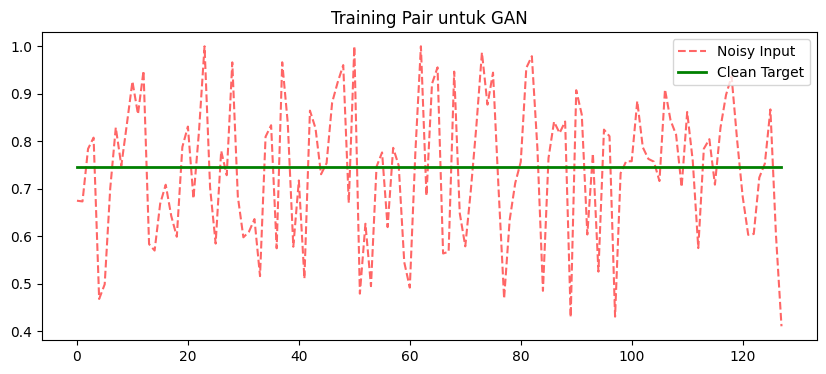

In [ ]:
def add_noise(signals, noise_factor=0.15):
    noise = np.random.normal(0, 1, signals.shape)
    noisy_signals = signals + noise_factor * noise
    return np.clip(noisy_signals, 0, 1)

# Siapkan pasangan training untuk GAN
# Input: Healthy + Noise -> Target: Healthy Original
X_train_gan_clean = torch.FloatTensor(X_healthy_raw)
X_train_gan_noisy = torch.FloatTensor(add_noise(X_healthy_raw))

gan_loader = DataLoader(TensorDataset(X_train_gan_noisy.unsqueeze(1), X_train_gan_clean.unsqueeze(1)),
                        batch_size=CONFIG['batch_size'], shuffle=True)

# Visualisasi Efek Noise
plt.figure(figsize=(10, 4))
plt.plot(X_train_gan_noisy[0], 'r--', label='Noisy Input', alpha=0.6)
plt.plot(X_train_gan_clean[0], 'g', label='Clean Target', linewidth=2)
plt.title("Training Pair untuk GAN")
plt.legend()
plt.show()

In [ ]:
class DenoiseGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = nn.Conv1d(1, 32, 4, 2, 1) # 128 -> 64
        self.e2 = nn.Conv1d(32, 64, 4, 2, 1) # 64 -> 32
        self.e3 = nn.Conv1d(64, 128, 4, 2, 1) # 32 -> 16

        # Decoder
        self.d1 = nn.ConvTranspose1d(128, 64, 4, 2, 1)
        self.d2 = nn.ConvTranspose1d(128, 32, 4, 2, 1) # +64 skip conn
        self.d3 = nn.ConvTranspose1d(64, 1, 4, 2, 1)   # +32 skip conn

    def forward(self, x):
        # Encode
        x1 = F.leaky_relu(self.e1(x), 0.2)
        x2 = F.leaky_relu(self.e2(x1), 0.2)
        x3 = F.leaky_relu(self.e3(x2), 0.2)

        # Decode with Skip Connections
        y1 = F.relu(self.d1(x3))
        y1 = torch.cat([y1, x2], dim=1) # Skip

        y2 = F.relu(self.d2(y1))
        y2 = torch.cat([y2, x1], dim=1) # Skip

        y3 = torch.sigmoid(self.d3(y2)) # Output 0-1
        return y3

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv1d(1, 32, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, 4, 2, 1), nn.BatchNorm1d(64), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * (CONFIG['seq_len']//4), 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

In [ ]:
generator = DenoiseGenerator().to(device)
discriminator = Discriminator().to(device)

opt_g = optim.Adam(generator.parameters(), lr=CONFIG['lr'], betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr=CONFIG['lr'], betas=(0.5, 0.999))
criterion_adv = nn.BCELoss()
criterion_pix = nn.L1Loss() # MAE Loss agar sinyal akurat

print("--- Training Denoising GAN ---")
for epoch in range(CONFIG['epochs_gan']):
    for real_noisy, real_clean in gan_loader:
        real_noisy, real_clean = real_noisy.to(device), real_clean.to(device)
        batch_size = real_noisy.size(0)

        # Label
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # 1. Train Generator
        opt_g.zero_grad()
        gen_clean = generator(real_noisy)

        loss_adv = criterion_adv(discriminator(gen_clean), valid)
        loss_pixel = criterion_pix(gen_clean, real_clean)

        loss_g = loss_adv + (100 * loss_pixel) # Prioritas pada pixel similarity
        loss_g.backward()
        opt_g.step()

        # 2. Train Discriminator
        opt_d.zero_grad()
        loss_real = criterion_adv(discriminator(real_clean), valid)
        loss_fake = criterion_adv(discriminator(gen_clean.detach()), fake)
        loss_d = (loss_real + loss_fake) / 2
        loss_d.backward()
        opt_d.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | G Loss: {loss_g.item():.4f} | D Loss: {loss_d.item():.4f}")

--- Training Denoising GAN ---
Epoch 10 | G Loss: 2.0279 | D Loss: 0.6142
Epoch 20 | G Loss: 2.6737 | D Loss: 0.4934
Epoch 30 | G Loss: 2.1563 | D Loss: 0.6007
Epoch 40 | G Loss: 1.5877 | D Loss: 0.6693
Epoch 50 | G Loss: 1.5919 | D Loss: 0.5036
Epoch 60 | G Loss: 1.5873 | D Loss: 0.5247
Epoch 70 | G Loss: 1.7734 | D Loss: 0.4286
Epoch 80 | G Loss: 1.5532 | D Loss: 0.6729
Epoch 90 | G Loss: 1.7190 | D Loss: 0.5555
Epoch 100 | G Loss: 1.3038 | D Loss: 0.6224
Epoch 110 | G Loss: 1.2581 | D Loss: 0.6829
Epoch 120 | G Loss: 1.2289 | D Loss: 0.7714
Epoch 130 | G Loss: 1.1057 | D Loss: 0.6408
Epoch 140 | G Loss: 1.0862 | D Loss: 0.6876
Epoch 150 | G Loss: 1.3817 | D Loss: 0.6908
Epoch 160 | G Loss: 1.1705 | D Loss: 0.6266
Epoch 170 | G Loss: 1.6831 | D Loss: 0.6747
Epoch 180 | G Loss: 1.3630 | D Loss: 0.6578
Epoch 190 | G Loss: 1.6510 | D Loss: 0.6124
Epoch 200 | G Loss: 1.1026 | D Loss: 0.6169
Epoch 210 | G Loss: 1.2628 | D Loss: 0.6120
Epoch 220 | G Loss: 1.5852 | D Loss: 0.5617
Epoch 230 

Membersihkan Data Healthy...
Membersihkan Data Sick...


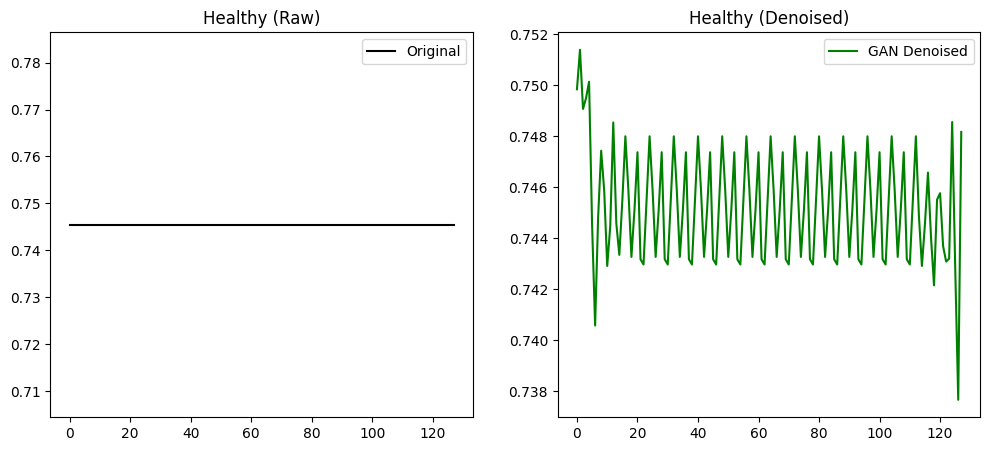

Dataset Klasifikasi Siap. Train: (9492, 128), Test: (2373, 128)


In [ ]:
def denoise_data(raw_data, model):
    model.eval()
    dataset = TensorDataset(torch.FloatTensor(raw_data).unsqueeze(1))
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    denoised_list = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            cleaned = model(imgs)
            denoised_list.append(cleaned.cpu().numpy().squeeze(1))

    return np.concatenate(denoised_list)

# --- PROSES DENOISING ---
print("Membersihkan Data Healthy...")
X_healthy_clean = denoise_data(X_healthy_raw, generator)

print("Membersihkan Data Sick...")
X_sick_clean = denoise_data(X_sick_raw, generator)

# Visualisasi Perbandingan Healthy Sebelum & Sesudah
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1); plt.plot(X_healthy_raw[10], 'k', label='Original'); plt.title("Healthy (Raw)"); plt.legend()
plt.subplot(1,2,2); plt.plot(X_healthy_clean[10], 'g', label='GAN Denoised'); plt.title("Healthy (Denoised)"); plt.legend()
plt.show()

# --- MENYIAPKAN DATASET AKHIR ---
# Label: 0 = Healthy, 1 = Sick
y_healthy = np.zeros(len(X_healthy_clean))
y_sick = np.ones(len(X_sick_clean))

X_final = np.concatenate([X_healthy_clean, X_sick_clean])
y_final = np.concatenate([y_healthy, y_sick])

# Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=True)

print(f"Dataset Klasifikasi Siap. Train: {X_train.shape}, Test: {X_test.shape}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- TRAINING HELPER (UPDATED) ---
def train_and_eval(model, name):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0005)
    crit = nn.BCELoss()

    train_dl = DataLoader(TensorDataset(torch.FloatTensor(X_train).unsqueeze(1), torch.FloatTensor(y_train).unsqueeze(1)), batch_size=32, shuffle=True)

    print(f"\nTraining {name}...")
    loss_history = [] # Array untuk menyimpan loss

    for ep in range(CONFIG['epochs_clf']):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
            loss_history.append(loss.item()) # Simpan loss per batch

    # Evaluasi
    model.eval()
    preds = []
    with torch.no_grad():
        test_in = torch.FloatTensor(X_test).unsqueeze(1).to(device)
        out = model(test_in).cpu().numpy()
        preds = (out > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, preds)
    print(f"[{name}] Accuracy: {acc:.4f}")

    # --- VISUALISASI PER MODEL ---
    plt.figure(figsize=(15, 4))

    # 1. Diagram Loss
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, label='Training Loss', color='red')
    plt.title(f'{name} - Loss History')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # 2. Confusion Matrix
    plt.subplot(1, 3, 2)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')

    # 3. Tabel Ground Truth (10 Data Pertama)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    df_table = pd.DataFrame({'Ground Truth': y_test[:10], 'Prediction': preds[:10]})
    table = plt.table(cellText=df_table.values, colLabels=df_table.columns, loc='center', cellLoc='center')
    table.set_fontsize(12)
    table.scale(1, 1.5)
    plt.title(f'{name} - Sample Prediction')

    plt.tight_layout()
    plt.show()

    return acc, preds


--- 1. SVM Classifier ---
[SVM] Accuracy: 0.7927


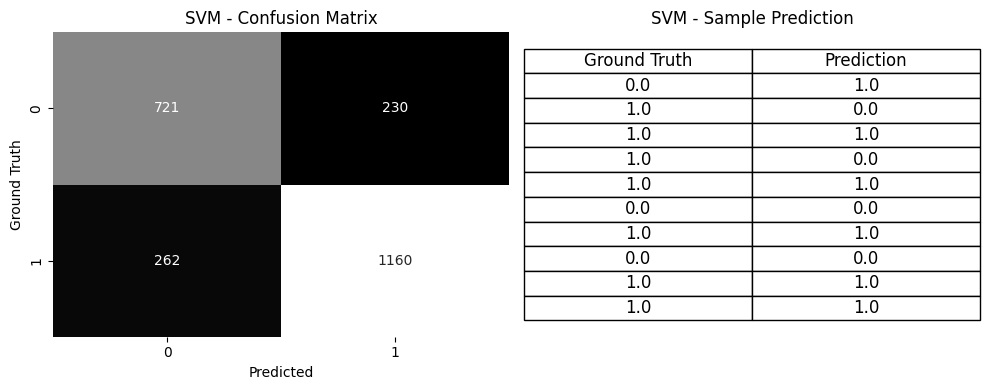

In [ ]:
print("\n--- 1. SVM Classifier ---")
# SVM butuh input 2D, jadi kita flatten signalnya
svm_in_train = X_train.reshape(X_train.shape[0], -1)
svm_in_test = X_test.reshape(X_test.shape[0], -1)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(svm_in_train, y_train)
svm_preds = clf_svm.predict(svm_in_test)
svm_acc = accuracy_score(y_test, svm_preds)
print(f"[SVM] Accuracy: {svm_acc:.4f}")

# Visualisasi SVM
plt.figure(figsize=(10, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, svm_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='gray', cbar=False)
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

# Tabel Ground Truth
plt.subplot(1, 2, 2)
plt.axis('off')
df_table = pd.DataFrame({'Ground Truth': y_test[:10], 'Prediction': svm_preds[:10]})
table = plt.table(cellText=df_table.values, colLabels=df_table.columns, loc='center', cellLoc='center')
table.set_fontsize(12)
table.scale(1, 1.5)
plt.title('SVM - Sample Prediction')

plt.tight_layout()
plt.show()


--- 2. Self-ResAttentioNet18 ---

Training ResAttentioNet...
[ResAttentioNet] Accuracy: 0.8095


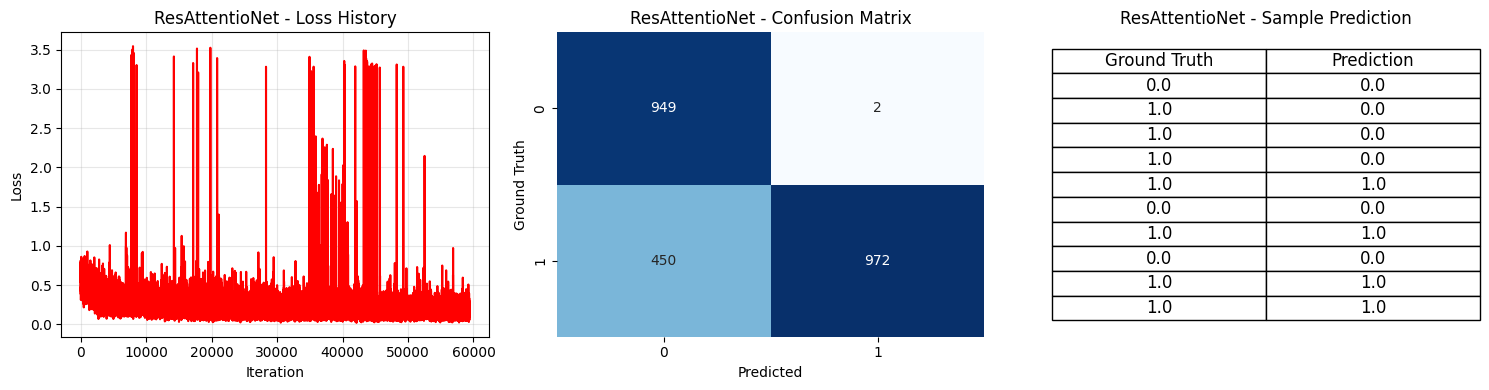

In [ ]:
print("\n--- 2. Self-ResAttentioNet18 ---")

# Definisi Model
class SelfAttention1D(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv1d(in_channels, in_channels//8, 1)
        self.key = nn.Conv1d(in_channels, in_channels//8, 1)
        self.value = nn.Conv1d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        B, C, W = x.size()
        q = self.query(x).view(B, -1, W).permute(0, 2, 1)
        k = self.key(x).view(B, -1, W)
        attn = F.softmax(torch.bmm(q, k), dim=-1)
        v = self.value(x).view(B, -1, W)
        out = torch.bmm(v, attn.permute(0, 2, 1)).view(B, C, W)
        return self.gamma * out + x

class ResAttentioNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(1, 32, 3, 1, 1), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 3, 1, 1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2)
        )
        self.attn = SelfAttention1D(64)
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (CONFIG['seq_len']//4), 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.feat(x)
        x = self.attn(x)
        return self.clf(x)

# Eksekusi
res_model = ResAttentioNet()
res_acc, res_preds = train_and_eval(res_model, "ResAttentioNet")


--- 3. BERT-TimeSeries ---

Training BERT...
[BERT] Accuracy: 0.8719


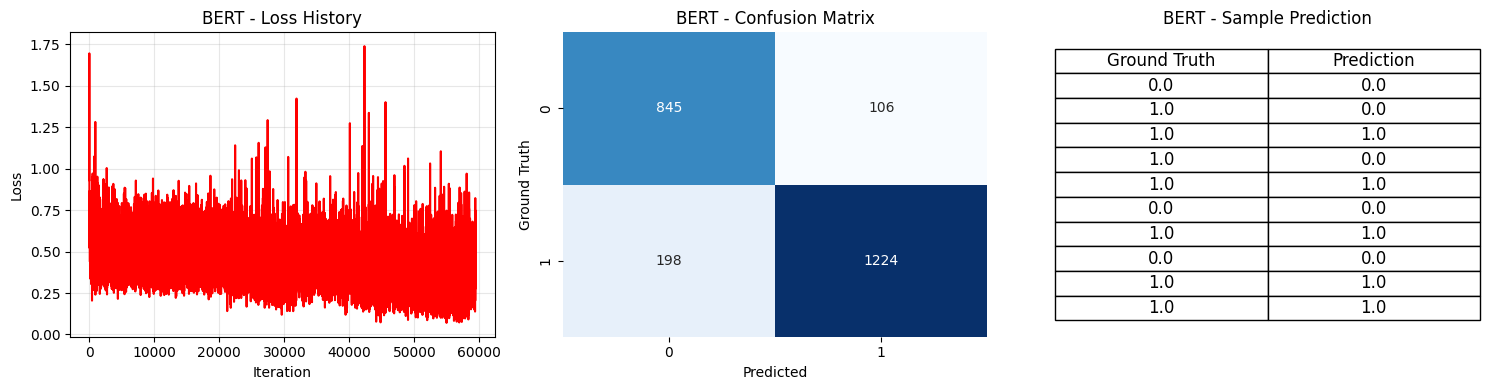

In [ ]:
print("\n--- 3. BERT-TimeSeries ---")

# Definisi Model
class BERT_Clf(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(1, 64)
        self.pos = nn.Parameter(torch.randn(1, CONFIG['seq_len'], 64))
        enc = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=128, batch_first=True)
        self.trans = nn.TransformerEncoder(enc, num_layers=2)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64 * CONFIG['seq_len'], 1), nn.Sigmoid())

    def forward(self, x):
        x = x.permute(0, 2, 1) # (B, Seq, Feat)
        x = self.proj(x) + self.pos
        x = self.trans(x)
        return self.head(x)

# Eksekusi
bert_model = BERT_Clf()
bert_acc, bert_preds = train_and_eval(bert_model, "BERT")

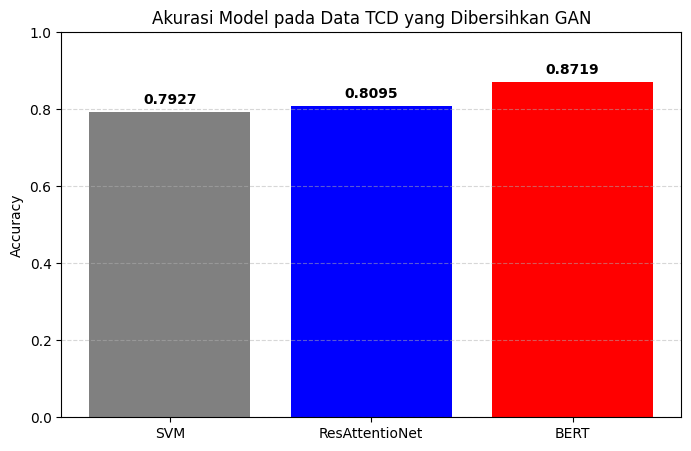

In [ ]:
# --- VISUALISASI FINAL ---
models = ['SVM', 'ResAttentioNet', 'BERT']
accs = [svm_acc, res_acc, bert_acc]

plt.figure(figsize=(8, 5))
plt.bar(models, accs, color=['gray', 'blue', 'red'])
plt.ylim(0, 1.0)
plt.title("Akurasi Model pada Data TCD yang Dibersihkan GAN")
plt.ylabel("Accuracy")
for i, v in enumerate(accs):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# # --- DEFINISI MODEL ---

# # 1. Self-ResAttentioNet18
# class SelfAttention1D(nn.Module):
#     def __init__(self, in_channels):
#         super().__init__()
#         self.query = nn.Conv1d(in_channels, in_channels//8, 1)
#         self.key = nn.Conv1d(in_channels, in_channels//8, 1)
#         self.value = nn.Conv1d(in_channels, in_channels, 1)
#         self.gamma = nn.Parameter(torch.zeros(1))
#     def forward(self, x):
#         B, C, W = x.size()
#         q = self.query(x).view(B, -1, W).permute(0, 2, 1)
#         k = self.key(x).view(B, -1, W)
#         attn = F.softmax(torch.bmm(q, k), dim=-1)
#         v = self.value(x).view(B, -1, W)
#         out = torch.bmm(v, attn.permute(0, 2, 1)).view(B, C, W)
#         return self.gamma * out + x

# class ResAttentioNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.feat = nn.Sequential(
#             nn.Conv1d(1, 32, 3, 1, 1), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
#             nn.Conv1d(32, 64, 3, 1, 1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2)
#         )
#         self.attn = SelfAttention1D(64)
#         self.clf = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * (CONFIG['seq_len']//4), 1),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         x = self.feat(x)
#         x = self.attn(x)
#         return self.clf(x)

# # 2. BERT-TimeSeries Classifier
# class BERT_Clf(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.proj = nn.Linear(1, 64)
#         self.pos = nn.Parameter(torch.randn(1, CONFIG['seq_len'], 64))
#         enc = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=128, batch_first=True)
#         self.trans = nn.TransformerEncoder(enc, num_layers=2)
#         self.head = nn.Sequential(nn.Flatten(), nn.Linear(64 * CONFIG['seq_len'], 1), nn.Sigmoid())

#     def forward(self, x):
#         x = x.permute(0, 2, 1) # (B, Seq, Feat)
#         x = self.proj(x) + self.pos
#         x = self.trans(x)
#         return self.head(x)

# # --- TRAINING HELPER ---
# def train_and_eval(model, name):
#     model = model.to(device)
#     opt = optim.Adam(model.parameters(), lr=0.0005)
#     crit = nn.BCELoss()

#     train_dl = DataLoader(TensorDataset(torch.FloatTensor(X_train).unsqueeze(1), torch.FloatTensor(y_train).unsqueeze(1)), batch_size=32, shuffle=True)

#     print(f"\nTraining {name}...")
#     for ep in range(CONFIG['epochs_clf']):
#         model.train()
#         for xb, yb in train_dl:
#             xb, yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             loss = crit(model(xb), yb)
#             loss.backward()
#             opt.step()

#     # Evaluasi
#     model.eval()
#     preds = []
#     with torch.no_grad():
#         test_in = torch.FloatTensor(X_test).unsqueeze(1).to(device)
#         out = model(test_in).cpu().numpy()
#         preds = (out > 0.5).astype(int).flatten()

#     acc = accuracy_score(y_test, preds)
#     print(f"[{name}] Accuracy: {acc:.4f}")
#     return acc, preds

# # --- EKSEKUSI ---

# # 1. SVM (Baseline)
# print("\n--- 1. SVM Classifier ---")
# # SVM butuh input 2D, jadi kita flatten signalnya
# svm_in_train = X_train.reshape(X_train.shape[0], -1)
# svm_in_test = X_test.reshape(X_test.shape[0], -1)
# clf_svm = SVC(kernel='rbf')
# clf_svm.fit(svm_in_train, y_train)
# svm_preds = clf_svm.predict(svm_in_test)
# svm_acc = accuracy_score(y_test, svm_preds)
# print(f"[SVM] Accuracy: {svm_acc:.4f}")

# # 2. ResAttentioNet
# print("\n--- 2. Self-ResAttentioNet18 ---")
# res_model = ResAttentioNet()
# res_acc, res_preds = train_and_eval(res_model, "ResAttentioNet")

# # 3. BERT
# print("\n--- 3. BERT-TimeSeries ---")
# bert_model = BERT_Clf()
# bert_acc, bert_preds = train_and_eval(bert_model, "BERT")

# # --- VISUALISASI FINAL ---
# models = ['SVM', 'ResAttentioNet', 'BERT']
# accs = [svm_acc, res_acc, bert_acc]

# plt.figure(figsize=(8, 5))
# plt.bar(models, accs, color=['gray', 'blue', 'red'])
# plt.ylim(0, 1.0)
# plt.title("Akurasi Model pada Data TCD yang Dibersihkan GAN")
# plt.ylabel("Accuracy")
# for i, v in enumerate(accs):
#     plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
# plt.show()